In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from datetime import timedelta

In [4]:
import matplotlib.pyplot as plt


In [5]:
# ---------- LOAD ----------
df = pd.read_csv('customer_shopping_data_new.csv')

In [6]:
# ---------- PREP (clean/minor fixes) ----------
# standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [7]:
# ensure invoice_date parsed
if 'invoice_date' in df.columns:
    # try day-first parsing then default
    df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce', dayfirst=True)
else:
    raise ValueError("invoice_date column is required in the dataset.")

In [8]:
# ensure numeric columns
for col in ['quantity', 'price', 'age']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [9]:
# create total_amount if not present
if 'total_amount' not in df.columns:
    if 'quantity' in df.columns and 'price' in df.columns:
        df['total_amount'] = df['quantity'].fillna(0) * df['price'].fillna(0)
    elif 'price' in df.columns:
        # assume price is total if no quantity
        df['total_amount'] = df['price'].fillna(0)
    else:
        raise ValueError("Need price or total_amount to compute revenues.")

In [10]:
# fallback for product and country columns
product_col = None
for c in ['product_id','product','product_name','sku','category']:
    if c in df.columns:
        product_col = c
        break

In [11]:
# For country-wise revenue: prefer 'country' then 'city' then 'shopping_mall'
location_col = None
for c in ['country','city','shopping_mall','store','location']:
    if c in df.columns:
        location_col = c
        break

In [12]:
# Add month column for monthly trend
df['invoice_month'] = df['invoice_date'].dt.to_period('M').dt.to_timestamp()

In [13]:
# ---------- 1) MONTHLY SALES TRENDS ----------
monthly = df.groupby('invoice_month', as_index=False)['total_amount'].sum().sort_values('invoice_month')
monthly.rename(columns={'total_amount':'monthly_revenue'}, inplace=True)
monthly.to_csv("monthly_sales_trends.csv", index=False)

In [14]:
# plot (saved)
plt.figure(figsize=(10,4))
plt.plot(monthly['invoice_month'], monthly['monthly_revenue'], marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig("monthly_sales_trend.png")
plt.close()

In [15]:
# ---------- 2) TOP PRODUCTS ----------
if product_col:
    top_products = (df.groupby(product_col, as_index=False)['total_amount']
                      .sum()
                      .sort_values('total_amount', ascending=False))
    top_products.to_csv("top_products_by_revenue.csv", index=False)
else:
    top_products = pd.DataFrame()
    print("No product column found; top_products empty. Using 'category' if available.")


In [16]:
# Show top 10
top_10_products = top_products.head(10)

In [17]:
# ---------- 3) COUNTRY-WISE (LOCATION) REVENUE ----------
if location_col:
    location_rev = (df.groupby(location_col, as_index=False)['total_amount']
                      .sum()
                      .sort_values('total_amount', ascending=False))
    location_rev.to_csv("location_revenue.csv", index=False)
else:
    location_rev = pd.DataFrame()
    print("No location-like column found. Add 'country' or 'shopping_mall' for geographic analysis.")

In [18]:
# ---------- 4) RFM SCORING & SEGMENTATION ----------
# We need a snapshot date (use last invoice_date + 1 day)
snapshot_date = df['invoice_date'].max() + pd.Timedelta(days=1)

In [19]:
# Aggregate per customer
if 'customer_id' not in df.columns:
    raise ValueError("customer_id column is required for RFM analysis.")
rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days,
    'invoice_no': 'nunique',   # count of invoices -> frequency
    'total_amount': 'sum'
}).reset_index().rename(columns={
    'invoice_date':'recency_days',
    'invoice_no':'frequency',
    'total_amount':'monetary'
})

In [20]:
# Replace possible zeros/negatives
rfm['monetary'] = rfm['monetary'].clip(lower=0)

In [21]:
# Score 1-5 for each dimension (5 = best)
rfm['r_score'] = pd.qcut(rfm['recency_days'], 5, labels=[5,4,3,2,1]).astype(int)   # recent -> low recency = good -> invert
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5]).astype(int)

In [22]:
# Combine RFM score
rfm['rfm_score'] = rfm['r_score'].map(str) + rfm['f_score'].map(str) + rfm['m_score'].map(str)
rfm['rfm_sum'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

In [23]:
# Simple segmentation rules (you can refine)
def rfm_segment(row):
    if row['r_score']>=4 and row['f_score']>=4 and row['m_score']>=4:
        return 'Champions'
    if row['r_score']>=3 and row['f_score']>=3 and row['m_score']>=3:
        return 'Loyal'
    if row['r_score']>=3 and (row['f_score']<3 or row['m_score']<3):
        return 'Potential'
    if row['r_score']<=2 and row['f_score']>=3:
        return 'At Risk'
    if row['r_score']<=2 and row['f_score']<=2:
        return 'Lost'
    return 'Others'

rfm['segment'] = rfm.apply(rfm_segment, axis=1)
rfm.to_csv("rfm_scores_segments.csv", index=False)


In [24]:
# ---------- 5) SEGMENT REVENUE ----------
# Merge segment back to transaction-level to compute revenue per segment
df = df.merge(rfm[['customer_id','segment']], on='customer_id', how='left')
segment_revenue = df.groupby('segment', as_index=False)['total_amount'].sum().sort_values('total_amount', ascending=False)
segment_revenue.to_csv("segment_revenue.csv", index=False)

In [25]:
# ---------- 6) CHURN RISK & REVENUE AT RISK ----------
# Define churn risk rules (example thresholds)
# High risk: recency_days > 180
# Medium risk: 90 < recency_days <= 180
# Low risk: recency_days <= 90

def churn_risk(recency_days):
    if recency_days > 180:
        return 'high'
    if recency_days > 90:
        return 'medium'
    return 'low'

rfm['churn_risk'] = rfm['recency_days'].apply(churn_risk)


In [26]:
# Revenue at risk = sum of monetary for customers in high or medium risk
revenue_risk = rfm.groupby('churn_risk', as_index=False)['monetary'].sum().sort_values('monetary', ascending=False)
revenue_risk.to_csv("revenue_by_churn_risk.csv", index=False)

In [27]:
# revenue at high risk specifically:
revenue_at_high_risk = revenue_risk.loc[revenue_risk['churn_risk']=='high', 'monetary'].sum()
revenue_at_high_risk = float(revenue_at_high_risk) if not np.isnan(revenue_at_high_risk) else 0.0


In [28]:
# ---------- 7) CUSTOMER PRIORITY SCORE ----------
# Example priority score = weighted R(0.3) + F(0.4) + M(0.3) normalized to 100
# First normalize r, f, m to 0-1 scale (use r_score 1-5 where 5 best)
rfm['r_norm'] = (rfm['r_score'] - 1) / 4.0
rfm['f_norm'] = (rfm['f_score'] - 1) / 4.0
rfm['m_norm'] = (rfm['m_score'] - 1) / 4.0

weights = {'r':0.3, 'f':0.4, 'm':0.3}
rfm['priority_score'] = (rfm['r_norm']*weights['r'] + rfm['f_norm']*weights['f'] + rfm['m_norm']*weights['m']) * 100
rfm['priority_score'] = rfm['priority_score'].round(2)

rfm[['customer_id','recency_days','frequency','monetary','r_score','f_score','m_score','rfm_sum','segment','churn_risk','priority_score']].to_csv("rfm_priority_churn.csv", index=False)

In [29]:
# ---------- 8) SIMPLE OUTPUT PRINTS ----------
print("Saved files:")
print(" - monthly_sales_trends.csv and monthly_sales_trend.png")
print(" - top_products_by_revenue.csv")
print(" - location_revenue.csv")
print(" - rfm_scores_segments.csv")
print(" - segment_revenue.csv")
print(" - revenue_by_churn_risk.csv")
print(" - rfm_priority_churn.csv")

print("\nQuick summaries:")
print("\nTop 10 products (by revenue):")
print(top_10_products.head(10).to_string(index=False) if not top_10_products.empty else "No product data")

print("\nMonthly revenue sample:")
print(monthly.tail())

print("\nSegment revenue:")
print(segment_revenue.to_string(index=False))

print("\nRevenue by churn risk:")
print(revenue_risk.to_string(index=False))


Saved files:
 - monthly_sales_trends.csv and monthly_sales_trend.png
 - top_products_by_revenue.csv
 - location_revenue.csv
 - rfm_scores_segments.csv
 - segment_revenue.csv
 - revenue_by_churn_risk.csv
 - rfm_priority_churn.csv

Quick summaries:

Top 10 products (by revenue):
       category  total_amount
       Clothing    5582988.40
          Shoes    3305136.19
     Technology    3085950.00
      Cosmetics     352928.80
           Toys     199772.16
          Books      45465.15
Food & Beverage      42138.11
       Souvenir      34556.58

Monthly revenue sample:
   invoice_month  monthly_revenue
22    2022-11-01        484818.13
23    2022-12-01        494892.35
24    2023-01-01        484474.01
25    2023-02-01        389840.42
26    2023-03-01         64557.89

Segment revenue:
  segment  total_amount
Potential    3065293.09
  At Risk    3028764.97
    Loyal    2601471.93
     Lost    2287618.26
Champions    1665787.14

Revenue by churn risk:
churn_risk   monetary
      high 9753

In [30]:
# Optional: save key dataframes to Excel workbook (multiple sheets)
with pd.ExcelWriter("analytics_summary.xlsx") as writer:
    monthly.to_excel(writer, sheet_name="monthly", index=False)
    if not top_products.empty:
        top_products.to_excel(writer, sheet_name="top_products", index=False)
    location_rev.to_excel(writer, sheet_name="location_revenue", index=False)
    rfm.to_excel(writer, sheet_name="rfm", index=False)
    segment_revenue.to_excel(writer, sheet_name="segment_revenue", index=False)
    revenue_risk.to_excel(writer, sheet_name="revenue_churn_risk", index=False)

print("\n✅ analytics_summary.xlsx saved with multiple sheets.")


✅ analytics_summary.xlsx saved with multiple sheets.


In [31]:
from sqlalchemy import create_engine

In [32]:
#cohort
# Ensure date is in datetime format
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce', dayfirst=True)

# Create invoice month
df['invoice_month'] = df['invoice_date'].dt.to_period('M').dt.to_timestamp()

# Identify each customer’s first purchase month (their cohort)
df['cohort_month'] = df.groupby('customer_id')['invoice_month'].transform('min')

# Calculate the months difference between purchase and cohort
def month_diff(end, start):
    return (end.year - start.year) * 12 + (end.month - start.month)

df['cohort_index'] = df.apply(lambda row: month_diff(row['invoice_month'], row['cohort_month']) + 1, axis=1)

# Create cohort table (number of active customers per month)
cohort_data = df.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()

# Pivot for visualization
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='customer_id')

# Calculate retention rates
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

# Save to Excel
retention.to_excel("cohort_retention_matrix.xlsx")

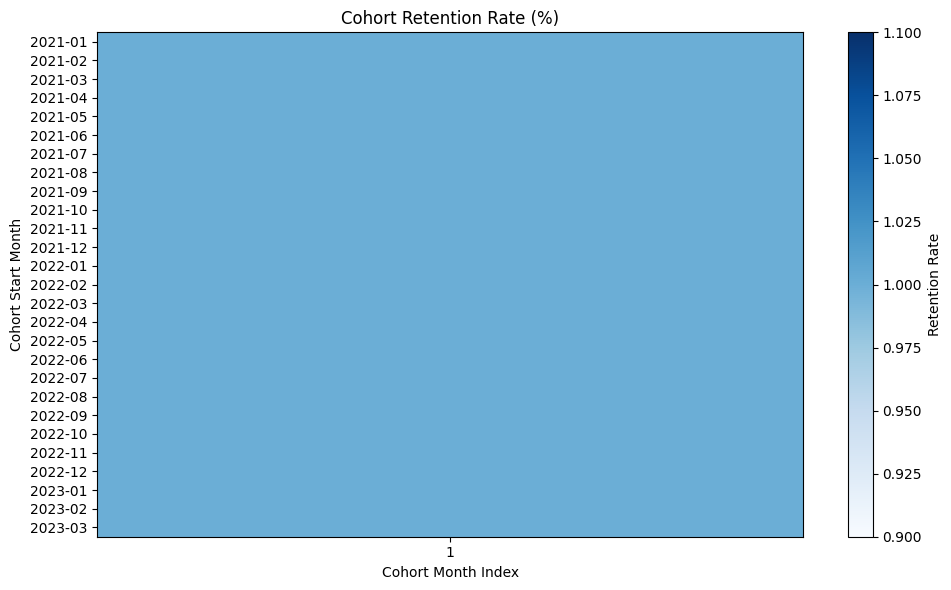

In [33]:
# Plot heatmap
plt.figure(figsize=(10,6))
plt.title('Cohort Retention Rate (%)')
plt.imshow(retention, cmap='Blues', aspect='auto')
plt.xticks(np.arange(len(retention.columns)), retention.columns)
plt.yticks(np.arange(len(retention.index)), [d.strftime('%Y-%m') for d in retention.index])
plt.colorbar(label='Retention Rate')
plt.xlabel('Cohort Month Index')
plt.ylabel('Cohort Start Month')
plt.tight_layout()
plt.show()

In [37]:
#  MySQL Database Connection Details
username = "root"               # your MySQL username
password = "1410"      # your MySQL password
host = "127.0.0.1"              # or your server IP
database = "Consumer_360"   # 👈 create this DB first in MySQL Workbench

# Create SQLAlchemy Engine
engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}/{database}")

# Upload DataFrame to MySQL
table_name = "customer_shopping_data"

df.to_sql(table_name, con=engine, index=False, if_exists='replace')

print("CSV imported successfully into MySQL!")
print(f"Database: {database}")
print(f"Table: {table_name}")
print(f"Rows inserted: {len(df)}")


CSV imported successfully into MySQL!
Database: Consumer_360
Table: customer_shopping_data
Rows inserted: 5000
